In [44]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
from gensim.models import Word2Vec
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import KFold
from sklearn.base import clone
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import spearmanr, sem
sns.set()

In [45]:
# Standardized metrics function to use on each model
def get_metrics(y_true, y_pred):

    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    spr = spearmanr(y_true, y_pred)
    return {
        'mse' : mse,
        'r2' : r2,
        'spearman': spearmanr(y_true, y_pred)[0]
    }

In [46]:
def cross_validate_regression(model, x, y, n_splits=10):

    kfold = KFold(n_splits=n_splits)
    
    # metric dict
    _metrics = {'mse': [],
                'r2': [],
                'spearman': []}
    
    for train_idx, test_idx in kfold.split(x, y):
        # build new network
        _model = clone(model)

        # get training data
        x_train = x[train_idx]
        y_true_train = y[train_idx]

        # get testing data
        x_test = x[test_idx]
        y_true_test = y[test_idx]

        # initialize an empty array same size as y_true
        y_pred = np.empty_like(y)

        # train on training data
        _model.fit(x_train, y_true_train)

        # predict testing data
        y_pred = _model.predict(x_test)
        
        # get regression metrics
        metrics_k = get_metrics(y_true_test, y_pred)

        _metrics['mse'].append(metrics_k['mse'])
        _metrics['r2'].append(metrics_k['r2'])
        _metrics['spearman'].append(metrics_k['spearman'])
    
    return _metrics

In [118]:
def cross_validate_regression_network(x, y, embSize, n_splits=10, numEpochs=5):
    # computes the spearman correlation coefficient for each cross validated data set
    # takes in a model (estimator object), pandas dataframe, x features and the y-feature to predict, as well
    # as the number of splits (default is 10)
    #
    # returns a list of spearman correlation coefficients with length equal to the input n_splits
    

    kfold = KFold(n_splits=n_splits)
    
    # metric dict
    _metrics = {'mse': [],
                'r2': [],
                'spearman': []}
    
    for train_idx, test_idx in kfold.split(x, y):
        # build new network
        backend.clear_session()

        _arch = [
        Flatten(input_shape=(embSize,)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1)
        ]

        model = Sequential(_arch)

        model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

        # get training data
        x_train = x[train_idx]
        y_true_train = y[train_idx]

        # get testing data
        x_test = x[test_idx]
        y_true_test = y[test_idx]

        # initialize an empty array same size as y_true
        y_pred = np.empty_like(y)

        # train on training data
        model.fit(x_train, y_true_train, epochs=numEpochs, batch_size=32)

        # predict testing data
        y_pred = model.predict(x_test)
        
        # get regression metrics
        metrics_k = get_metrics(y_true_test, y_pred)

        _metrics['mse'].append(metrics_k['mse'])
        _metrics['r2'].append(metrics_k['r2'])
        _metrics['spearman'].append(metrics_k['spearman'])
    
    return _metrics

In [48]:
def w2vEmbedding(texts, embeddingSize=200) -> Word2Vec:
    # Train the Word2Vec model from Gensim. 
    # Below are the hyperparameters that are most relevant. 
    # But feel free to explore other 
    # options too:
    sg = 1 # skip-gram
    window = 5
    vector_size = embeddingSize
    min_count = 1

    model = Word2Vec(sg=sg, window=window, vector_size=vector_size, min_count=min_count)
    model.build_vocab(texts)
    return model

In [49]:
def transformerEmbedding(texts) -> SentenceTransformer:
    bert = SentenceTransformer('distilbert-base-nli-mean-tokens')
    return bert.encode(texts, convert_to_numpy=True)

In [50]:
EMBEDDINGS_SIZE = 25
EMBEDDING_LENGTH_ON = EMBEDDINGS_SIZE * 20 # for the 20-mer sequence
EMBEDDING_LENGTH_OFF = EMBEDDINGS_SIZE * 20 # for the 20-mer off-target sequence
TRANSFORMER_SIZE = 768

### Preprocessing & Embedding

,Spacer Sequence,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,G1,GA1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,GTAATGGCTTCCTCGTGAGT,0.789849,0,0,0,0,0,1,1,0,...,0,0,1,1,0,0,0,1,0,-24.633240
1,GCTCGTGCGAGTGATAGACC,0.552807,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,-26.546780
2,CACGGACGGTATATGGCAGG,0.149130,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-26.207115
3,TACTTCTGCGAGACACGGAC,0.767944,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,-25.848845
4,CGGCCCACGCTACTACAGTT,0.627909,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,-27.072340


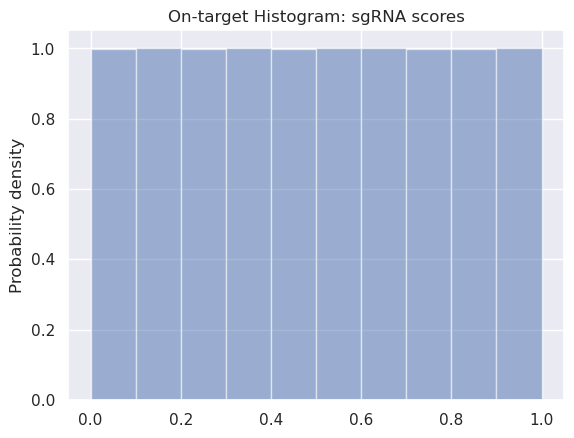

In [51]:
df = pd.read_csv("../data/AIO_onTarget_V2_Featurized.csv", index_col=0)
plt.hist(df["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.ylabel('Probability density')
plt.title("On-target Histogram: sgRNA scores")
df.head()

In [52]:
df.shape

(18928, 1636)

,Spacer Sequence,sgRNA Normalized,A1,AA1,AG1,AC1,AT1,A?,G1,GA1,...,TGT,TCA,TCG,TCC,TCT,TTA,TTG,TTC,TTT,Delta G
0,TACCCTGGGACTGTACCCCC,0.604353,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,-26.433045
1,ACCCTTGCTGCACGACCTGC,0.730003,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,-28.734370
2,TCGCTCGCCCCGCTCTTCCT,0.229828,0,0,0,0,0,0,0,0,...,0,0,1,1,1,0,0,1,0,-29.864820
3,TGACGCCTCGGACGTGTCTG,0.232793,0,0,0,0,0,1,0,0,...,1,0,1,0,1,0,0,0,0,-28.405050
4,CGTCATAGCCAATCTTCTTC,0.399647,0,0,0,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,-23.162190


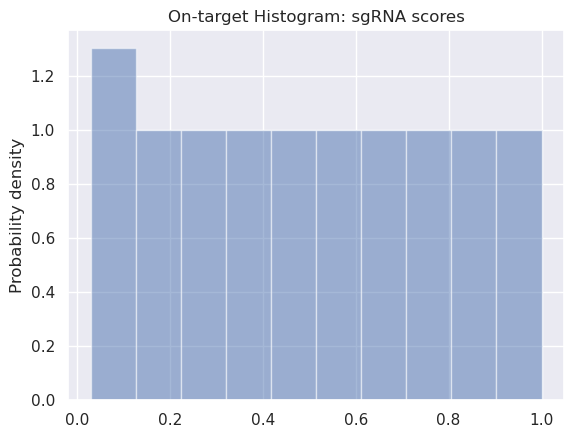

In [53]:
dfOff = pd.read_csv("../data/AIO_offTarget_V2_Featurized.csv", index_col=0)
plt.hist(dfOff["sgRNA Normalized"], alpha=0.5, density=True, label='Normalized sgRNA scores')
plt.ylabel('Probability density')
plt.title("On-target Histogram: sgRNA scores")
dfOff.head()

In [54]:
w2vmodel_sequence = w2vEmbedding(df["Spacer Sequence"], EMBEDDINGS_SIZE)
print('Vocab size {}'.format(len(w2vmodel_sequence.wv)))
vocab_seq = len(w2vmodel_sequence.wv)
w2vmodel_sequence.wv.save_word2vec_format('sequence_embeddings.txt', binary=False)

Vocab size 4


In [55]:
embeddings = []
for _seq in df["Spacer Sequence"]:
    xEmb = []
    for _x in _seq:
        xEmb.extend(w2vmodel_sequence.wv[_x])
    embeddings.append(xEmb)

print(np.array(embeddings).shape)
df["Embedded Sequences"] = embeddings

(18928, 500)


In [56]:
trEmb = transformerEmbedding(df["Spacer Sequence"])

df["Transformer Sequences"] = list(trEmb)

dfEmb = df.copy(deep=True)[["Spacer Sequence", "sgRNA Normalized", "Embedded Sequences", "Transformer Sequences"]]
dfEmb.head()

,Spacer Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,GTAATGGCTTCCTCGTGAGT,0.789849,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.8801969, 0.32914335, 1.1517115, -0.4121802..."
1,GCTCGTGCGAGTGATAGACC,0.552807,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.5003629, 0.20317358, 1.230608, -0.48018143..."
2,CACGGACGGTATATGGCAGG,0.149130,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...","[-0.77627754, 0.4267836, 0.7114664, -0.4843815..."
3,TACTTCTGCGAGACACGGAC,0.767944,"[0.0022871399, 0.029767632, -0.003253131, -0.0...","[-0.6333257, 0.40072635, 0.8997507, -0.537243,..."
4,CGGCCCACGCTACTACAGTT,0.627909,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...","[-0.8275509, 0.21623036, 1.0080041, -0.1860265..."


In [57]:
dfEmb.to_csv("embedded sequence data.csv")

In [58]:
data = pd.read_csv("embedded sequence data.csv")
dfEmb = data.drop(data.columns[0], axis=1) # drop unnamed column
dfEmb.head()

,Spacer Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,GTAATGGCTTCCTCGTGAGT,0.789849,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-8.80196929e-01 3.29143345e-01 1.15171146e+...
1,GCTCGTGCGAGTGATAGACC,0.552807,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-5.00362873e-01 2.03173578e-01 1.23060799e+...
2,CACGGACGGTATATGGCAGG,0.149130,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...",[-0.77627754 0.4267836 0.7114664 -0.484381...
3,TACTTCTGCGAGACACGGAC,0.767944,"[0.0022871399, 0.029767632, -0.003253131, -0.0...",[-0.6333257 0.40072635 0.8997507 -0.537243...
4,CGGCCCACGCTACTACAGTT,0.627909,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...",[-8.27550888e-01 2.16230363e-01 1.00800407e+...


In [59]:
w2vmodel_sequence = w2vEmbedding(dfOff["Spacer Sequence"], EMBEDDINGS_SIZE)

print('Vocab size {}'.format(len(w2vmodel_sequence.wv)))
vocab_seq = len(w2vmodel_sequence.wv)
w2vmodel_sequence.wv.save_word2vec_format('sequence_embeddings.txt', binary=False)

embeddings = []
for _seq in dfOff["Spacer Sequence"]:
    xEmb = []
    for _x in _seq:
        xEmb.extend(w2vmodel_sequence.wv[_x])
    embeddings.append(xEmb)

print(np.array(embeddings).shape)
dfOff["Embedded Sequences"] = embeddings

trEmb = transformerEmbedding(dfOff["Spacer Sequence"])

dfOff["Transformer Sequences"] = list(trEmb)

dfEmbOff = dfOff.copy(deep=True)[["Spacer Sequence", "sgRNA Normalized", "Embedded Sequences", "Transformer Sequences"]]
dfEmbOff.head()

Vocab size 4
(64751, 500)


,Spacer Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,TACCCTGGGACTGTACCCCC,0.604353,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.6844983, 0.32545617, 1.1369966, -0.2328178..."
1,ACCCTTGCTGCACGACCTGC,0.730003,"[-0.03263167, 0.017983193, -0.016548304, 0.003...","[-0.5825761, 0.11436693, 1.2382472, -0.3425781..."
2,TCGCTCGCCCCGCTCTTCCT,0.229828,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.47986773, 0.014203413, 1.3465703, -0.02461..."
3,TGACGCCTCGGACGTGTCTG,0.232793,"[-0.013621463, -0.0037856055, 0.023074294, -0....","[-0.6668119, 0.12491163, 0.88532573, -0.299219..."
4,CGTCATAGCCAATCTTCTTC,0.399647,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...","[-0.7485277, 0.35522404, 0.9028547, -0.2164551..."


In [60]:
dfEmbOff.to_csv("off-target embedded sequence data.csv")

In [61]:
data = pd.read_csv("off-target embedded sequence data.csv")
dfEmbOff = data.drop(data.columns[0], axis=1) # drop unnamed column
dfEmbOff.head()

,Spacer Sequence,sgRNA Normalized,Embedded Sequences,Transformer Sequences
0,TACCCTGGGACTGTACCCCC,0.604353,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-6.84498310e-01 3.25456172e-01 1.13699663e+...
1,ACCCTTGCTGCACGACCTGC,0.730003,"[-0.03263167, 0.017983193, -0.016548304, 0.003...",[-5.82576096e-01 1.14366934e-01 1.23824716e+...
2,TCGCTCGCCCCGCTCTTCCT,0.229828,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-4.79867727e-01 1.42034134e-02 1.34657025e+...
3,TGACGCCTCGGACGTGTCTG,0.232793,"[-0.013621463, -0.0037856055, 0.023074294, -0....",[-6.66811883e-01 1.24911629e-01 8.85325730e-...
4,CGTCATAGCCAATCTTCTTC,0.399647,"[-0.002144909, 0.0009457254, 0.020413399, 0.03...",[-0.7485277 0.35522404 0.9028547 -0.216455...


### On-target Modeling

In [122]:
xRawOn = df.drop(["sgRNA Normalized", "Spacer Sequence", "Embedded Sequences", "Transformer Sequences"], axis=1).values
xEmbOn = np.array([np.fromstring(_x[1:-1], sep=', ') for _x in dfEmb["Embedded Sequences"].values])
xTrOn = np.array([np.fromstring(_x[1:-1].replace("\n",""), sep=' ') for _x in dfEmb["Transformer Sequences"].values])
yOn = dfEmb["sgRNA Normalized"].values

In [123]:
xRawTrain, xRawTest, xEmbTrain, xEmbTest, xTrTrain, xTrTest, yTrain, yTest = train_test_split(xRawOn, xEmbOn, xTrOn, yOn, test_size=0.1)

In [124]:
model = BayesianRidge()
model.fit(xRawTrain, yTrain)
yPredBrOn = model.predict(xRawTest)

In [125]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5)
model.fit(xRawTrain, yTrain)
yPredGbrtOn = model.predict(xRawTest)

In [126]:
_arch = [
Flatten(input_shape=(EMBEDDING_LENGTH_ON,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
yPredEmb = np.empty_like(yTest)

# train on training data
model.fit(xEmbTrain, yTrain, epochs=50, batch_size=32)

# predict testing data
yPredEmbOn = model.predict(xEmbTest)

Epoch 1/50
533/533 [==============================] - 1s 729us/step - loss: 0.0799
Epoch 2/50
533/533 [==============================] - 0s 912us/step - loss: 0.0741
Epoch 3/50
533/533 [==============================] - 1s 985us/step - loss: 0.0706
Epoch 4/50
533/533 [==============================] - 1s 954us/step - loss: 0.0671
Epoch 5/50
533/533 [==============================] - 0s 687us/step - loss: 0.0643
Epoch 6/50
533/533 [==============================] - 0s 762us/step - loss: 0.0619
Epoch 7/50
533/533 [==============================] - 0s 726us/step - loss: 0.0596
Epoch 8/50
533/533 [==============================] - 0s 718us/step - loss: 0.0575
Epoch 9/50
533/533 [==============================] - 0s 749us/step - loss: 0.0553
Epoch 10/50
533/533 [==============================] - 0s 727us/step - loss: 0.0536
Epoch 11/50
533/533 [==============================] - 0s 689us/step - loss: 0.0518
Epoch 12/50
533/533 [==============================] - 0s 662us/step - loss: 0.0499
E

In [127]:
_arch = [
Flatten(input_shape=(TRANSFORMER_SIZE,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
y_pred = np.empty_like(yTest)

# train on training data
model.fit(xTrTrain, yTrain, epochs=50, batch_size=32)

# predict testing data
yPredTrOn = model.predict(xTrTest)

Epoch 1/50
533/533 [==============================] - 1s 876us/step - loss: 0.0917
Epoch 2/50
533/533 [==============================] - 1s 945us/step - loss: 0.0812
Epoch 3/50
533/533 [==============================] - 0s 919us/step - loss: 0.0809
Epoch 4/50
533/533 [==============================] - 0s 924us/step - loss: 0.0803
Epoch 5/50
533/533 [==============================] - 0s 819us/step - loss: 0.0795
Epoch 6/50
533/533 [==============================] - 0s 827us/step - loss: 0.0795
Epoch 7/50
533/533 [==============================] - 0s 811us/step - loss: 0.0790
Epoch 8/50
533/533 [==============================] - 0s 887us/step - loss: 0.0785
Epoch 9/50
533/533 [==============================] - 1s 968us/step - loss: 0.0783
Epoch 10/50
533/533 [==============================] - 0s 783us/step - loss: 0.0780
Epoch 11/50
533/533 [==============================] - 0s 744us/step - loss: 0.0775
Epoch 12/50
533/533 [==============================] - 0s 796us/step - loss: 0.0781
E

/tmp/ipykernel_27085/153271637.py:30: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


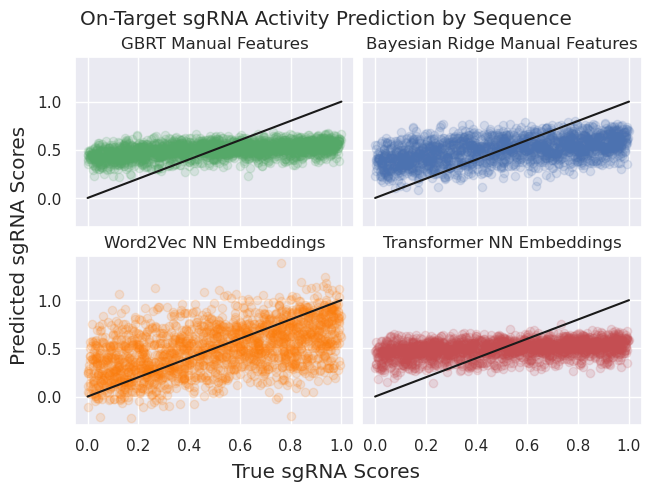

In [128]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, layout="constrained", sharex=True, sharey=True)

ax1 = plt.subplot(2,2,1)
ax1.scatter(yTest, yPredGbrtOn, c='g', alpha=0.15, label="Manual Features - GBRT")
ax1.plot([0, 1], [0, 1], 'k-', label="True Values")
ax1.set_title("GBRT Manual Features")


ax2 = plt.subplot(2,2,2)
ax2.scatter(yTest, yPredBrOn, c='b', alpha=0.15, label="Manual Features - Bayesian Ridge")
ax2.plot([0, 1], [0, 1], 'k-', label="True Values")
ax2.set_title("Bayesian Ridge Manual Features")

ax3 = plt.subplot(2,2,3)
ax3.scatter(yTest, yPredEmbOn, c='tab:orange', alpha=0.15, label="Word2Vec Embeddings")
ax3.plot([0, 1], [0, 1], 'k-', label="True Values")
ax3.set_title("Word2Vec NN Embeddings")

ax4 = plt.subplot(2,2,4)
ax4.scatter(yTest, yPredTrOn, c='r', alpha=0.15, label="Transformer Embeddings")
ax4.plot([0, 1], [0, 1], 'k-', label="True Values")
ax4.set_title("Transformer NN Embeddings")

# plt.legend()
# plt.axis("equal")
fig.supylabel("Predicted sgRNA Scores")
fig.supxlabel("True sgRNA Scores")
fig.suptitle("On-Target sgRNA Activity Prediction by Sequence")
fig.savefig("on-target sgrna activity prediction.png")
fig.show()

In [129]:
model = BayesianRidge()
br_metrics = cross_validate_regression(model, xRawOn, yOn)

model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5)
gbrt_metrics = cross_validate_regression(model, xRawOn, yOn)

w2vnn_metrics = cross_validate_regression_network(xEmbOn, yOn, embSize=EMBEDDING_LENGTH_ON, numEpochs=50)

tfnn_metrics = cross_validate_regression_network(xTrOn, yOn, embSize=TRANSFORMER_SIZE, numEpochs=50)

Epoch 1/50
533/533 [==============================] - 1s 791us/step - loss: 0.0790
Epoch 2/50
533/533 [==============================] - 0s 916us/step - loss: 0.0732
Epoch 3/50
533/533 [==============================] - 1s 947us/step - loss: 0.0694
Epoch 4/50
533/533 [==============================] - 0s 903us/step - loss: 0.0662
Epoch 5/50
533/533 [==============================] - 0s 919us/step - loss: 0.0634
Epoch 6/50
533/533 [==============================] - 0s 758us/step - loss: 0.0603
Epoch 7/50
533/533 [==============================] - 0s 617us/step - loss: 0.0579
Epoch 8/50
533/533 [==============================] - 0s 663us/step - loss: 0.0557
Epoch 9/50
533/533 [==============================] - 0s 676us/step - loss: 0.0532
Epoch 10/50
533/533 [==============================] - 0s 686us/step - loss: 0.0508
Epoch 11/50
533/533 [==============================] - 0s 873us/step - loss: 0.0490
Epoch 12/50
533/533 [==============================] - 0s 812us/step - loss: 0.0469
E

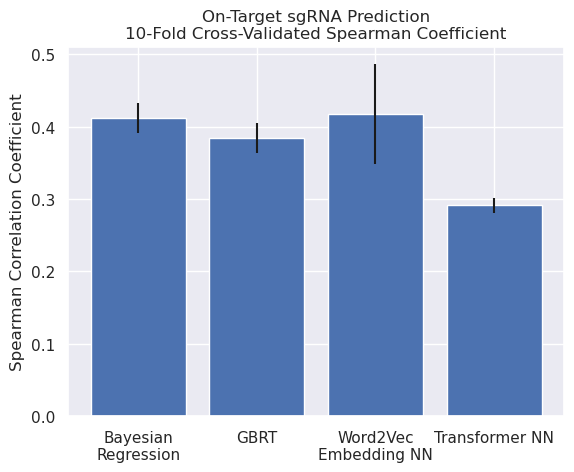

In [130]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Spearman Correlation Coefficient")
plt.title("On-Target sgRNA Prediction\n10-Fold Cross-Validated Spearman Coefficient")
plt.savefig("on-target sgrna spearman barchart.png")

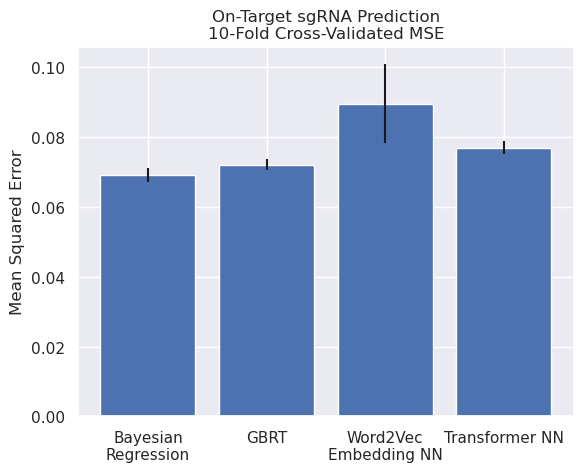

In [131]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['mse']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['mse']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Mean Squared Error")
plt.title("On-Target sgRNA Prediction\n10-Fold Cross-Validated MSE")
plt.savefig("on-target sgrna mse barchart.png")

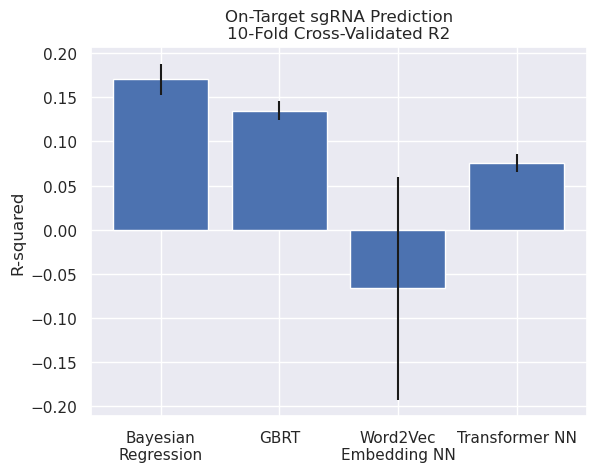

In [132]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['r2']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['r2']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("R-squared")
plt.title("On-Target sgRNA Prediction\n10-Fold Cross-Validated R2")
plt.savefig("on-target sgrna r2 barchart.png")

### Off-target Modeling

In [133]:
xRaw = dfOff.drop(["sgRNA Normalized", "Spacer Sequence", "Embedded Sequences", "Transformer Sequences"], axis=1).values
xEmb = np.array([np.fromstring(_x[1:-1], sep=', ') for _x in dfEmbOff["Embedded Sequences"].values])
xTr = np.array([np.fromstring(_x[1:-1].replace("\n",""), sep=' ') for _x in dfEmbOff["Transformer Sequences"].values])
y = dfOff["sgRNA Normalized"].values

In [134]:
xRawTrain, xRawTest, xEmbTrain, xEmbTest, xTrTrain, xTrTest, yTrain, yTest = train_test_split(xRaw, xEmb, xTr, y, test_size=0.1)

In [135]:
model = BayesianRidge()
model.fit(xRawTrain, yTrain)
yPredBr = model.predict(xRawTest)

In [136]:
model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5)
model.fit(xRawTrain, yTrain)

yPredGbrt = model.predict(xRawTest)

In [137]:
_arch = [
Flatten(input_shape=(EMBEDDING_LENGTH_OFF,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
yPredEmb = np.empty_like(yTest)

# train on training data
model.fit(xEmbTrain, yTrain, epochs=50, batch_size=32)

# predict testing data
yPredEmb = model.predict(xEmbTest)

Epoch 1/50
1822/1822 [==============================] - 2s 711us/step - loss: 0.0515
Epoch 2/50
1822/1822 [==============================] - 1s 672us/step - loss: 0.0298
Epoch 3/50
1822/1822 [==============================] - 1s 701us/step - loss: 0.0237
Epoch 4/50
1822/1822 [==============================] - 1s 688us/step - loss: 0.0215
Epoch 5/50
1822/1822 [==============================] - 1s 700us/step - loss: 0.0203
Epoch 6/50
1822/1822 [==============================] - 2s 890us/step - loss: 0.0192
Epoch 7/50
1822/1822 [==============================] - 1s 710us/step - loss: 0.0184
Epoch 8/50
1822/1822 [==============================] - 1s 667us/step - loss: 0.0179
Epoch 9/50
1822/1822 [==============================] - 1s 611us/step - loss: 0.0173
Epoch 10/50
1822/1822 [==============================] - 1s 653us/step - loss: 0.0168
Epoch 11/50
1822/1822 [==============================] - 1s 684us/step - loss: 0.0163
Epoch 12/50
1822/1822 [==============================] - 1s 770

In [138]:
_arch = [
Flatten(input_shape=(TRANSFORMER_SIZE,)),
Dense(128, activation='relu'),
Dense(64, activation='relu'),
Dense(1)
]

model = Sequential(_arch)

model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))

# initialize an empty array same size as y_true
y_pred = np.empty_like(yTest)

# train on training data
model.fit(xTrTrain, yTrain, epochs=50, batch_size=32)

# predict testing data
yPredTr = model.predict(xTrTest)

Epoch 1/50
1822/1822 [==============================] - 2s 879us/step - loss: 0.0472
Epoch 2/50
1822/1822 [==============================] - 2s 827us/step - loss: 0.0376
Epoch 3/50
1822/1822 [==============================] - 2s 884us/step - loss: 0.0361
Epoch 4/50
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0345
Epoch 5/50
1822/1822 [==============================] - 2s 1ms/step - loss: 0.0326
Epoch 6/50
1822/1822 [==============================] - 2s 919us/step - loss: 0.0318
Epoch 7/50
1822/1822 [==============================] - 2s 925us/step - loss: 0.0313
Epoch 8/50
1822/1822 [==============================] - 1s 756us/step - loss: 0.0303
Epoch 9/50
1822/1822 [==============================] - 2s 870us/step - loss: 0.0300
Epoch 10/50
1822/1822 [==============================] - 2s 832us/step - loss: 0.0293
Epoch 11/50
1822/1822 [==============================] - 1s 708us/step - loss: 0.0289
Epoch 12/50
1822/1822 [==============================] - 1s 764us/s

/tmp/ipykernel_27085/3226874758.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


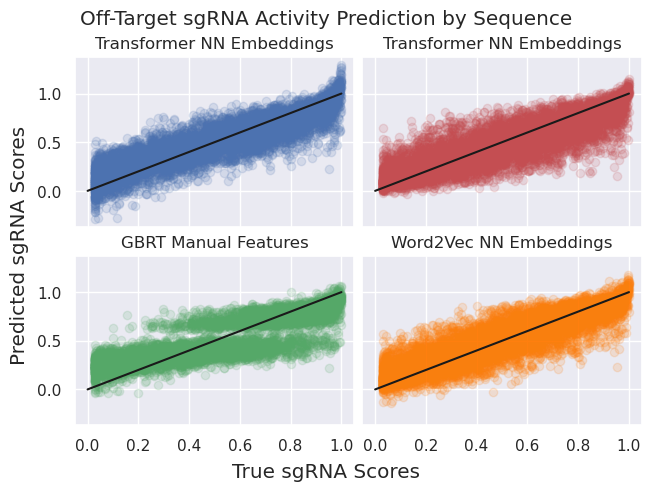

In [142]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, layout="constrained", sharex=True, sharey=True)

ax1 = plt.subplot(2,2,1)
ax1.scatter(yTest, yPredBr, c='b', alpha=0.15, label="Transformer Embeddings")
ax1.plot([0, 1], [0, 1], 'k-', label="True Values")
ax1.set_title("Transformer NN Embeddings")

ax2 = plt.subplot(2,2,2)
ax2.scatter(yTest, yPredTr, c='r', alpha=0.15, label="Transformer Embeddings")
ax2.plot([0, 1], [0, 1], 'k-', label="True Values")
ax2.set_title("Transformer NN Embeddings")

ax3 = plt.subplot(2,2,3)
ax3.scatter(yTest, yPredGbrt, c='g', alpha=0.15, label="Manual Features - GBRT")
ax3.plot([0, 1], [0, 1], 'k-', label="True Values")
ax3.set_title("GBRT Manual Features")

ax4 = plt.subplot(2,2,4)
ax4.scatter(yTest, yPredEmb, c='tab:orange', alpha=0.15, label="Word2Vec Embeddings")
ax4.plot([0, 1], [0, 1], 'k-', label="True Values")
ax4.set_title("Word2Vec NN Embeddings")

fig.supylabel("Predicted sgRNA Scores")
fig.supxlabel("True sgRNA Scores")
fig.suptitle("Off-Target sgRNA Activity Prediction by Sequence")
fig.savefig("off-target sgrna activity prediction.png")
fig.show()

In [143]:
model = BayesianRidge()
br_metrics = cross_validate_regression(model, xRaw, y)

model = GradientBoostingRegressor(n_estimators=100, max_depth=2, min_samples_split=5)
gbrt_metrics = cross_validate_regression(model, xRaw, y)

w2vnn_metrics = cross_validate_regression_network(xEmb, y, embSize=EMBEDDING_LENGTH_OFF, numEpochs=50)

tfnn_metrics = cross_validate_regression_network(xTr, y, embSize=TRANSFORMER_SIZE, numEpochs=50)

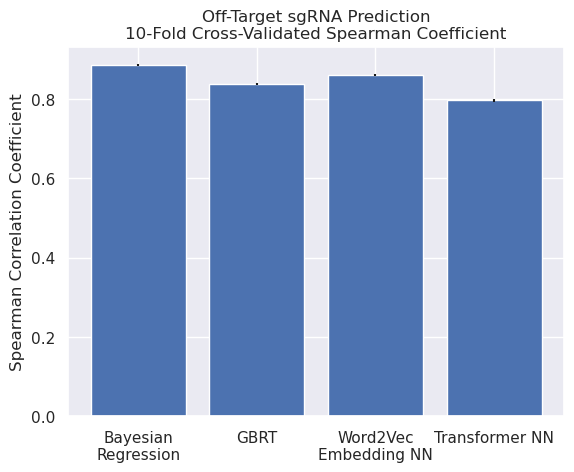

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['spearman']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Spearman Correlation Coefficient")
plt.title("Off-Target sgRNA Prediction\n10-Fold Cross-Validated Spearman Coefficient")
plt.savefig("off-target sgrna spearman barchart.png")

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['mse']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['mse']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("Mean Squared Error")
plt.title("Off-Target sgRNA Prediction\n10-Fold Cross-Validated MSE")
plt.savefig("off-target sgrna mse barchart.png")

In [ ]:
plt.bar(["Bayesian\nRegression", "GBRT", "Word2Vec\nEmbedding NN", "Transformer NN"],
         [np.mean(metrics['r2']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]],
         yerr=[sem(metrics['r2']) for metrics in [br_metrics, gbrt_metrics, w2vnn_metrics, tfnn_metrics]])
plt.ylabel("R-squared")
plt.title("Off-Target sgRNA Prediction\n10-Fold Cross-Validated R-squared")
plt.savefig("off-target sgrna r2 barchart.png")

### LSTM Modeling

In [43]:
# TODO